In [1]:
import pandas as pd

def decode_base(bits):
    base_dict = {(0, 0): 'A', (0, 1): 'C', (1, 0): 'G', (1, 1): 'U'}
    return base_dict.get(tuple(bits), 'A')

def decode_structure(bits):
    struct_dict = {(0, 0): '.', (0, 1): '(', (1, 0): ')'}
    return struct_dict.get(tuple(bits), '.')

def decode_428_bit_row(row_428):
    sequence_bits = row_428[:214]
    structure_bits = row_428[214:]
    sequence = ''.join(decode_base(sequence_bits[i:i+2]) for i in range(0, len(sequence_bits), 2))
    structure = ''.join(decode_structure(structure_bits[i:i+2]) for i in range(0, len(structure_bits), 2))
    return sequence, structure

df_bits = pd.read_csv("decoded_428bit_samples.csv")
decoded_sequences, decoded_structures = [], []

for _, row in df_bits.iterrows():
    row_bits = row.tolist()
    seq, struct = decode_428_bit_row(row_bits)
    decoded_sequences.append(seq)
    decoded_structures.append(struct)

decoded_df = pd.DataFrame({"sequence": decoded_sequences, "structure": decoded_structures})


In [2]:
def is_bracket_balanced(struct):
    count = 0
    for c in struct:
        if c == '(': count += 1
        elif c == ')':
            count -= 1
            if count < 0: return False
    return count == 0

def get_base_pairings(struct):
    stack, pairings = [], {}
    for i, c in enumerate(struct):
        if c == '(': stack.append(i)
        elif c == ')':
            if stack:
                j = stack.pop()
                pairings[i] = j
                pairings[j] = i
    return pairings

def is_valid_pair(b1, b2):
    return (b1, b2) in [('A','U'), ('U','A'), ('G','C'), ('C','G'), ('G','U'), ('U','G')]

def validate_rna(seq, struct):
    if not is_bracket_balanced(struct):
        return False, "Unbalanced bracket"
    pairings = get_base_pairings(struct)
    for i, j in pairings.items():
        if not is_valid_pair(seq[i], seq[j]):
            return False, f"Invalid pair: {seq[i]}-{seq[j]}"
    return True, "Valid"

decoded_df["valid"] = False
decoded_df["validation_msg"] = ""

for idx, row in decoded_df.iterrows():
    valid, msg = validate_rna(row["sequence"], row["structure"])
    decoded_df.at[idx, "valid"] = valid
    decoded_df.at[idx, "validation_msg"] = msg


In [3]:
import RNA  # ViennaRNA binding

def compute_energy(seq, struct):
    try:
        return RNA.energy_of_struct(seq, struct)
    except:
        return None

decoded_df["vienna_energy"] = decoded_df.apply(
    lambda row: compute_energy(row["sequence"], row["structure"]) if row["valid"] else None,
    axis=1
)


In [4]:
df_orig = pd.read_csv("most_probable_structure.csv")
set_orig_structs = set(df_orig["structure"])
set_gen_structs = set(decoded_df[decoded_df["valid"]]["structure"])

new_structs = set_gen_structs - set_orig_structs
common_structs = set_gen_structs & set_orig_structs

print("Totali generati:", len(decoded_df))
print("Validi:", decoded_df["valid"].sum())
print("Strutture generate uniche:", len(set_gen_structs))
print("Strutture nuove:", len(new_structs))
print("Strutture già note:", len(common_structs))


Totali generati: 1000
Validi: 82
Strutture generate uniche: 27
Strutture nuove: 23
Strutture già note: 4


In [5]:
# Dataset filtrato solo valido
valid_df = decoded_df[decoded_df["valid"]]

# Report statistico
summary_df = pd.DataFrame({
    "total_generated": [len(decoded_df)],
    "valid_generated": [len(valid_df)],
    "invalid_generated": [len(decoded_df) - len(valid_df)],
    "unique_structures_generated": [len(set_gen_structs)],
    "new_structures": [len(new_structs)],
    "known_structures": [len(common_structs)],
    "mean_energy": [valid_df["vienna_energy"].mean()],
    "min_energy": [valid_df["vienna_energy"].min()],
    "max_energy": [valid_df["vienna_energy"].max()]
})

# Salvataggi
valid_df.to_csv("decoded_rna_valid_only.csv", index=False)
summary_df.to_csv("rna_generation_summary.csv", index=False)


In [7]:
# Ricalcola insieme delle strutture conosciute dal dataset originale
df_orig = pd.read_csv("most_probable_structure.csv")  # o usa direttamente se già caricato
known_structs = set(df_orig["structure"])

# Ricalcola l'insieme delle strutture generate valide
generated_structs = set(valid_df["structure"])

# Suddividi in nuove e conosciute
new_structs = generated_structs - known_structs
overlap_structs = generated_structs & known_structs
# Filtra nuove strutture valide
valid_new = valid_df[valid_df["structure"].isin(new_structs)]
valid_known = valid_df[valid_df["structure"].isin(overlap_structs)]

# Statistiche energia
print("Energia media (nuove):", valid_new["vienna_energy"].mean())
print("Energia media (note):", valid_known["vienna_energy"].mean())
print("Numero nuove strutture valide:", len(valid_new))
print("Numero strutture note valide:", len(valid_known))


Energia media (nuove): -35.240000597635905
Energia media (note): -16.10000010899135
Numero nuove strutture valide: 75
Numero strutture note valide: 7


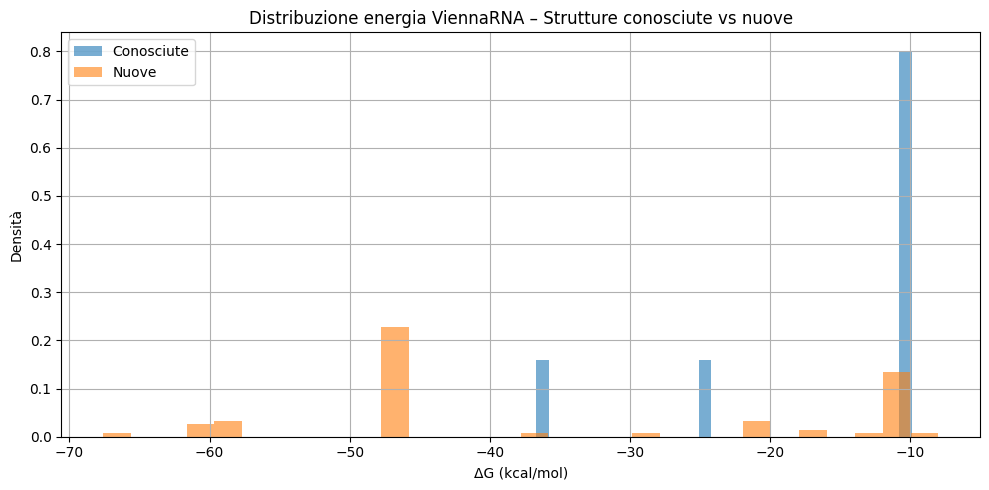

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(valid_known["vienna_energy"], bins=30, alpha=0.6, label="Conosciute", density=True)
plt.hist(valid_new["vienna_energy"], bins=30, alpha=0.6, label="Nuove", density=True)
plt.title("Distribuzione energia ViennaRNA – Strutture conosciute vs nuove")
plt.xlabel("ΔG (kcal/mol)")
plt.ylabel("Densità")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


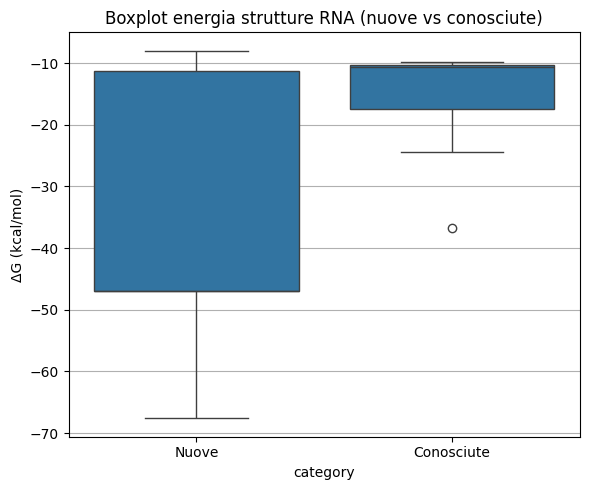

In [9]:
import seaborn as sns

# Crea DataFrame aggregato
energy_df = pd.DataFrame({
    "energy": list(valid_new["vienna_energy"]) + list(valid_known["vienna_energy"]),
    "category": ["Nuove"] * len(valid_new) + ["Conosciute"] * len(valid_known)
})

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(x="category", y="energy", data=energy_df)
plt.title("Boxplot energia strutture RNA (nuove vs conosciute)")
plt.ylabel("ΔG (kcal/mol)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
